# 01. Data Ingestion & Exploratory Data Analysis (EDA)
**Project:** Climate-Sensitive Health Forecasting (Dengue - Davao Pilot)\
**Author:** Edsequille Publico

### **Goal**
To create a "Golden Dataset" (Analytical Base Table) that merges weekly disease surveillance data with daily climate records.

### **Pipeline**
1.  **Ingest** raw CSVs from the Project C-CHAIN dataset.
2.  **Filter** for `Dengue` cases in `Davao City` (Chosen for high data density).
3.  **Transform** Daily Weather Data $\rightarrow$ Weekly Aggregates (Sum/Mean).
4.  **Merge** datasets on time index.
5.  **Export** clean data for Feature Engineering.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Settings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (15, 6)

RAW_DIR = '/kaggle/input/dengue-defensor'
PROCESSED_DIR = '/kaggle/working/'
os.makedirs(PROCESSED_DIR, exist_ok=True)

# File Paths
CLIMATE_PATH = os.path.join(RAW_DIR, 'climate_atmosphere.csv')
HEALTH_PATH = os.path.join(RAW_DIR, 'disease_pidsr_totals.csv')
LOC_PATH = os.path.join(RAW_DIR, 'location.csv')

# Target Definition (Davao City)
TARGET_CITY_NAME = 'Davao City'
TARGET_PCODE = 'PH112402000' # Found via location.csv
TARGET_DISEASE = 'DENGUE'

print("✅ Environment Configured.")

✅ Environment Configured.


In [2]:
# --- DATA LOADING ---

try:
    df_climate_raw = pd.read_csv(CLIMATE_PATH)
    df_health_raw = pd.read_csv(HEALTH_PATH)
    
    print(f"Climate Raw Shape: {df_climate_raw.shape}")
    print(f"Health Raw Shape:  {df_health_raw.shape}")
    
except FileNotFoundError as e:
    print(f"❌ Error: {e}")
    print("Check that your CSV files are in the '../data/raw/' directory.")

Climate Raw Shape: (6421095, 13)
Health Raw Shape:  (74880, 9)


In [4]:
# --- HEALTH DATA PROCESSING ---

# 1. Normalize Column Names
health = df_health_raw.copy()
health.columns = [c.lower().strip() for c in health.columns]

# 2. Filter for Dengue
# Using string contains to catch 'Dengue Fever', 'Dengue Hemorrhagic', etc.
health = health[health['disease_common_name'].str.contains(TARGET_DISEASE, case=False, na=False)]

# 3. Filter for Davao City
# We use the P-Code for Davao City (PH112402000)
health = health[health['adm3_pcode'] == TARGET_PCODE]

# 4. Create Date Index
# FIX: The dataset already has a 'date' column. We just convert it.
health['date'] = pd.to_datetime(health['date'])

# 5. Aggregate
# Summing cases in case there are multiple entries per week
health_weekly = health.groupby('date')['case_total'].sum().reset_index()
health_weekly = health_weekly.set_index('date').sort_index()
health_weekly.columns = ['cases']

print(f"✅ Health Data Cleaned for {TARGET_CITY_NAME}. Weeks found: {len(health_weekly)}")
print("Sample Data:")
print(health_weekly.head())

✅ Health Data Cleaned for Davao City. Weeks found: 780
Sample Data:
            cases
date             
2008-01-07     37
2008-01-14     41
2008-01-21     31
2008-01-28     32
2008-02-04     44


In [7]:
# --- CLIMATE DATA PROCESSING (FIXED) ---

# 1. Load Location File (Crucial for mapping City -> Barangays)
df_loc = pd.read_csv(LOC_PATH)

# 2. Get all Barangay Codes (adm4) for our Target City
# We filter location.csv to find rows where the City Name is 'Davao City'
target_barangays = df_loc[df_loc['adm3_en'] == TARGET_CITY_NAME]['adm4_pcode'].unique()

print(f"📍 Found {len(target_barangays)} Barangays in {TARGET_CITY_NAME}.")

# 3. Clean Climate Data
climate = df_climate_raw.copy()

# Rename columns to match our standard (pr -> rainfall, tave -> tmean)
column_map = {
    'pr': 'rainfall',
    'tave': 'tmean', 
    'rh': 'rh',
    'tmax': 'tmax',
    'tmin': 'tmin'
}
climate = climate.rename(columns=column_map)

# 4. Filter for Target Barangays
# We keep only rows where the 'adm4_pcode' is in our Davao City list
climate = climate[climate['adm4_pcode'].isin(target_barangays)]

# 5. Convert Date
climate['date'] = pd.to_datetime(climate['date'])

# 6. Aggregation Strategy (The Science Part)
# The data is by Barangay (Spatial) and by Day (Temporal).
# Step A: Spatial Aggregation (Get one value per DAY for the whole CITY)
# - Rainfall: Mean across barangays (Average rainfall in the city that day)
# - Temp: Mean across barangays
climate_daily = climate.groupby('date').agg({
    'rainfall': 'mean',
    'tmean': 'mean',
    'tmax': 'mean',
    'tmin': 'mean',
    'rh': 'mean'
})

# Step B: Temporal Aggregation (Resample Daily -> Weekly)
# - Rainfall: Sum (Total rain accumulated over the week)
# - Temp: Mean (Average temp over the week)
climate_weekly = climate_daily.resample('W-MON').agg({
    'rainfall': 'sum', 
    'tmean': 'mean',
    'tmax': 'max', # Peak heat of the week
    'tmin': 'min',
    'rh': 'mean'
})

print(f"✅ Climate Data Processed. Weeks found: {len(climate_weekly)}")
print("Sample Data:")
print(climate_weekly.head())

📍 Found 183 Barangays in Davao City.
✅ Climate Data Processed. Weeks found: 1044
Sample Data:
             rainfall      tmean       tmax       tmin         rh
date                                                             
2003-01-06  17.656885  25.626202  30.273607  22.488415  78.108725
2003-01-13  13.353443  25.622084  30.930874  21.023115  78.001998
2003-01-20   0.000000  25.328095  30.147923  22.241530  79.665550
2003-01-27  49.815683  25.759149  29.916776  22.807869  82.274091
2003-02-03  25.124426  25.690484  30.173443  22.847268  81.391124


In [8]:
# --- MERGING ---

# Inner Join: Keeps only the timeline where we have BOTH weather and disease data
df_merged = pd.merge(climate_weekly, health_weekly, left_index=True, right_index=True, how='inner')

# Impute Missing Values (if any short gaps exist)
df_merged = df_merged.fillna(method='ffill')

print(f"✅ Final Dataset Shape: {df_merged.shape}")
print(f"Date Range: {df_merged.index.min().date()} to {df_merged.index.max().date()}")

df_merged.tail()

✅ Final Dataset Shape: (780, 6)
Date Range: 2008-01-07 to 2022-12-26


,rainfall,tmean,tmax,tmin,rh,cases
date,,,,,,
2022-11-28,28.681858,26.198876,30.675301,22.564863,80.383622,94
2022-12-05,52.374098,25.892108,30.397596,22.924426,80.409774,72
2022-12-12,25.956831,26.448595,31.008852,23.212896,78.580258,98
2022-12-19,36.686995,26.160796,30.705191,23.154645,78.729219,70
2022-12-26,47.671694,26.014106,30.430710,22.973825,84.126120,35


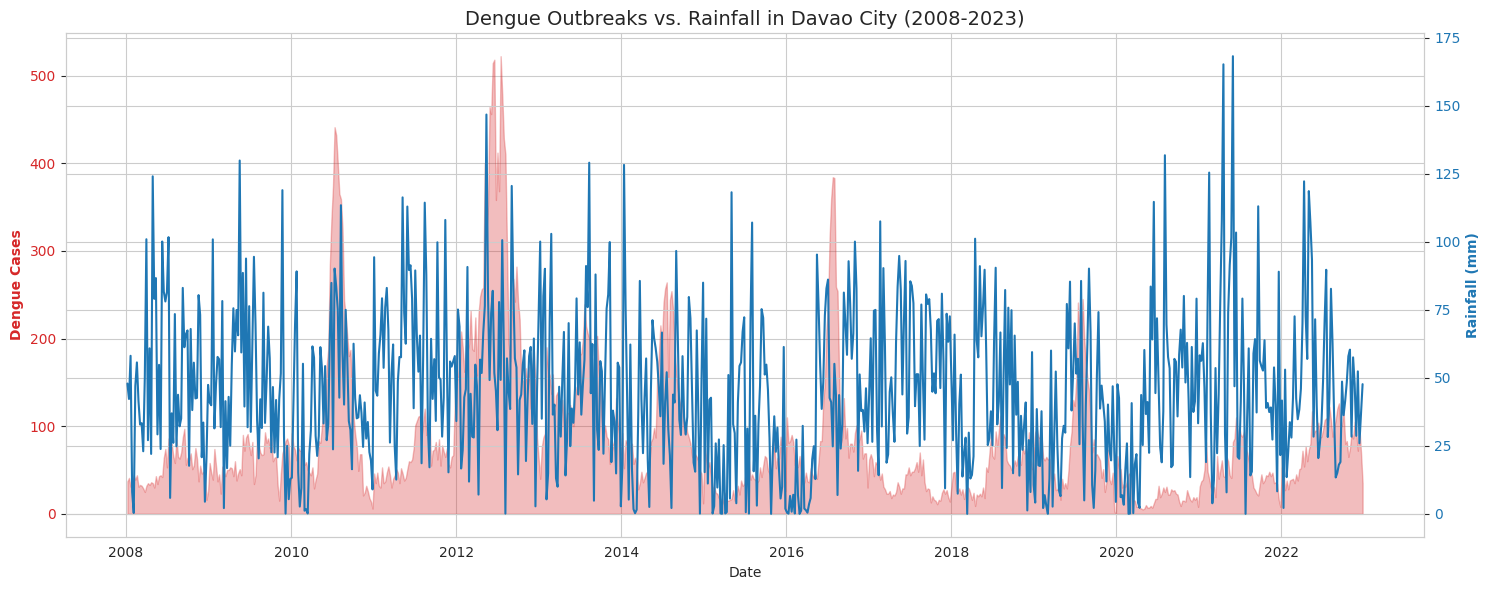

In [9]:
# --- VISUALIZATION ---

# Create a dual-axis plot to see the relationship
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot Cases (Area Chart)
color_cases = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Dengue Cases', color=color_cases, fontweight='bold')
ax1.fill_between(df_merged.index, df_merged['cases'], color=color_cases, alpha=0.3, label='Dengue Cases')
ax1.tick_params(axis='y', labelcolor=color_cases)

# Plot Rainfall (Line Chart)
ax2 = ax1.twinx()
color_rain = 'tab:blue'
ax2.set_ylabel('Rainfall (mm)', color=color_rain, fontweight='bold')
ax2.plot(df_merged.index, df_merged['rainfall'], color=color_rain, lw=1.5, label='Rainfall')
ax2.tick_params(axis='y', labelcolor=color_rain)

plt.title(f'Dengue Outbreaks vs. Rainfall in {TARGET_CITY_NAME} (2008-2023)', fontsize=14)
fig.tight_layout()
plt.show()

In [10]:
# --- EXPORT ---

output_file = os.path.join(PROCESSED_DIR, '01_davao_dengue_merged.csv')
df_merged.to_csv(output_file)

print(f"✅ Saved clean data to: {output_file}")
print("🚀 Ready for Notebook 02: Feature Engineering")

✅ Saved clean data to: /kaggle/working/01_davao_dengue_merged.csv
🚀 Ready for Notebook 02: Feature Engineering
